<a href="https://colab.research.google.com/github/terencetachiona/covid-19-icu-predictions/blob/master/Terence_Tachiona_Data_Scientist_Practical_Zimnat_Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://www.zimnat.co.zw/wp-content/uploads/2017/04/zimnat-web-logo.png) <center>

<h3 align="center"> DATA SCIENTIST PRACTICAL ASSESSMENT

<h3 align="center"> Notebook done and submitted by 

Terence Tachiona

tachiona0607@gmail.com


**Introduction**

This notebook will outline the data preparation, model creation and  evaluation, aiming to build a model that we consider to be the most clinically relevant to the problem, that is to do an early identfication of patients who need a bed in the ICU. As there are many features, we tried to reduce them to reduce the complexity of the model and using the window is something that is important to note, as well as excluding patients from ICU =1 (the removal of 32 of the pd.crosstab). apply ensemble with strong classifiers sucha as the Random Forest Classifer. Supervised clustering will also be applied and model evaluated using Shapley values.

**Aim**

The aim is to provide tertiary and quarternary hospitals with the most accurate answer, so ICU resources can be arranged or patient transfer can be scheduled.

**Task**

Predict admission to the ICU of confirmed COVID-19 cases.
Based on the data available, is it feasible to predict which patients will need intensive care unit support?

**Methodology**
1. Data Preparation
Missing data and Windows selection
2. Model Creation
Data split: Stratified 70/30 split. Models: Random Forest.
3. Evaluation.
The predictions are analysied for F1 Score, Accuracy, Precision Recall & ROC AUC. 

Results
Can we predict which inpatient will need intensive care unit (ICU)?

Key Take Aways
1.	Looks like using window 0-2 and all the usable data obtains the best relevance to the problem at hand.

2. To ensure a more robust model. Instead of taking the mean of the 3 predictions. A formula such as one on my github displayed below could be used. 


In [ ]:
from sklearn import (preprocessing, ensemble, model_selection,
                     metrics, pipeline, base, decomposition)
#Use to import the file into google Colab drive
from google.colab import files 
#Use to import io, which opens the file from the Colab drive
import io
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported")


Libraries imported


**Data Preparation**

### **Load data**

In [ ]:
# This will open a widget when run that will enable you to browse the files on your local storage drive.
uploaded = files.upload()

Saving Min_of_Health_Covid19_ICU_Prediction.xlsx to Min_of_Health_Covid19_ICU_Prediction (1).xlsx


In [ ]:
df = pd.read_excel(uploaded['Min_of_Health_Covid19_ICU_Prediction.xlsx'])
df.sample(10)


,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
19,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,-0.002798,-0.546256,-0.270189,-0.535593,0.033571,0.694035,0.086420,-0.538462,-0.301887,-0.517241,-0.035714,0.736842,-0.381443,-0.6250,-0.521368,-0.857143,0.120879,0.171717,0.145299,-0.286486,0.477612,-0.272727,0.623188,1.000000,-0.078261,-0.190184,0.251908,-0.352941,-0.047619,-0.171717,-0.308696,-0.057718,-0.069094,-0.329749,-0.047619,-0.172436,ABOVE_12,0
886,177,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2-4,0
829,165,0,30th,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.105263,-0.105263,-0.105263,-0.105263,-1.0,-0.529412,-0.529412,-0.529412,-0.529412,-1.0,-0.905759,-0.905759,-0.905759,-0.905759,-1.0,-0.121951,-0.121951,-0.121951,-0.121951,-1.0,-0.268293,-0.268293,-0.268293,-0.268293,-1.0,-0.965463,-0.965463,...,-0.978029,-1.0,-0.168000,-0.285858,-0.151125,-0.220827,0.156629,0.715453,-0.160494,-0.276923,-0.207547,-0.241379,0.142857,0.736842,-0.546392,-0.7250,-0.538462,-0.857143,0.120879,0.373737,0.333333,0.167568,0.761194,0.636364,0.333333,0.894737,0.252174,0.423313,0.557252,0.529412,-0.285714,-0.414141,0.073292,0.434445,0.088200,0.296188,-0.295446,-0.414650,ABOVE_12,1
1445,289,0,30th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.997533,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-2,0
1774,354,0,60th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.979069,-0.979069,...,-0.980804,-1.0,-0.144033,-0.719658,-0.385744,-0.623352,-0.019841,0.713450,-0

In [ ]:
print('{:,} rows and {:,} cols'.format(*df.shape))
print('{:,} unique patients'.format(df.PATIENT_VISIT_IDENTIFIER.nunique()))


1,925 rows and 231 cols
385 unique patients


There are 385 unique patients

In [ ]:
# data types 
df.dtypes


PATIENT_VISIT_IDENTIFIER        int64
AGE_ABOVE65                     int64
AGE_PERCENTIL                  object
GENDER                          int64
DISEASE GROUPING 1            float64
                               ...   
RESPIRATORY_RATE_DIFF_REL     float64
TEMPERATURE_DIFF_REL          float64
OXYGEN_SATURATION_DIFF_REL    float64
WINDOW                         object
ICU                             int64
Length: 231, dtype: object

In [ ]:
#  categorical features
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(exclude=['object']).columns
print(df[cat_cols].columns)


Index(['AGE_PERCENTIL', 'WINDOW'], dtype='object')


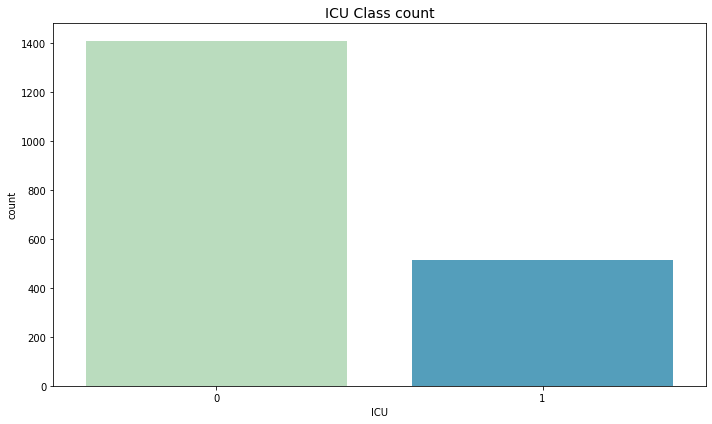

In [ ]:
# Label ICU 
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('ICU Class count', fontsize=14)
sns.countplot(df['ICU'], palette='GnBu')
plt.tight_layout()


In [ ]:
# count class 

class_1 = len(df[df['ICU']==1])
class_0 = len(df[df['ICU']==0])

# show 
print('\n')
print('Outside the ICU: {}'.format(class_0))
print('Inside the ICU: {}'.format(class_1))





Outside the ICU: 1410
Inside the ICU: 515


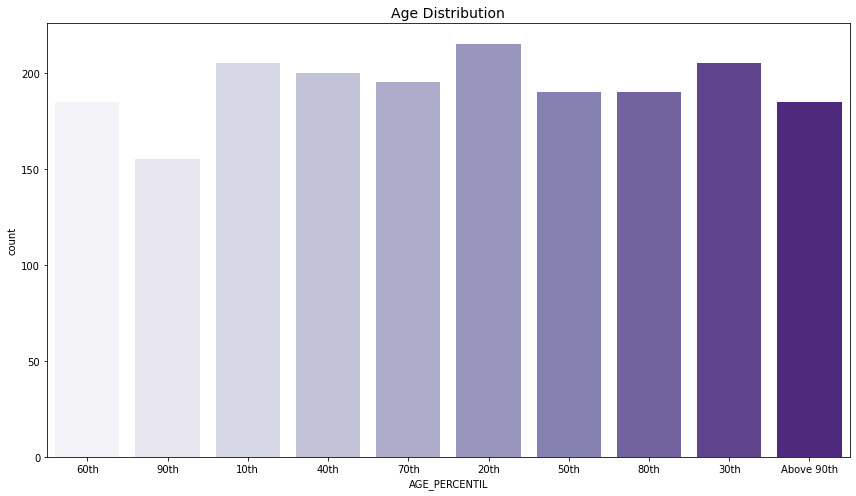

In [ ]:
# category aggregation function

def aggregate(df, col, arg, title):
  
  # category values 
  range_1 = len(df[df[col]==arg])
  show = print('{}: {}'.format(title,range_1))
  return show
# age distribution
plt.figure(figsize=(12,7))
plt.title('Age Distribution', fontsize=14)
sns.countplot(df['AGE_PERCENTIL'], palette='Purples')
plt.tight_layout()


In [ ]:
# Summary ages 
print('----- AGE COUNT -----')
print('\n')
aggregate(df, 'AGE_PERCENTIL', '10th', 'AGE 10th')
aggregate(df, 'AGE_PERCENTIL', '20th', 'AGE 20th')
aggregate(df, 'AGE_PERCENTIL', '30th', 'AGE 30th')
aggregate(df, 'AGE_PERCENTIL', '40th', 'AGE 40th')
aggregate(df, 'AGE_PERCENTIL', '50th', 'AGE 50th')
aggregate(df, 'AGE_PERCENTIL', '60th', 'AGE 60th')
aggregate(df, 'AGE_PERCENTIL', '70th', 'AGE 70th')
aggregate(df, 'AGE_PERCENTIL', '80th', 'AGE 80th')
aggregate(df, 'AGE_PERCENTIL', '90th', 'AGE 90th')
aggregate(df, 'AGE_PERCENTIL', 'Above 90th', 'AGE above 90th')


----- AGE COUNT -----


AGE 10th: 205
AGE 20th: 215
AGE 30th: 205
AGE 40th: 200
AGE 50th: 190
AGE 60th: 185
AGE 70th: 195
AGE 80th: 190
AGE 90th: 155
AGE above 90th: 185


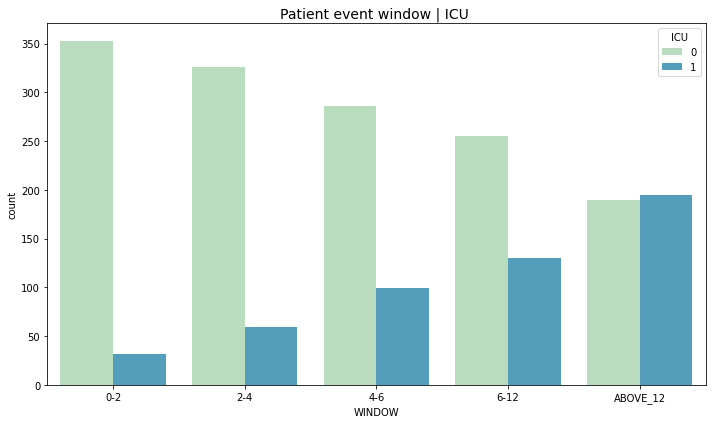

In [ ]:

# Patient event window 
plt.figure(figsize=(10,6))
plt.title('Patient event window | ICU ', fontsize=14)
sns.countplot(df['WINDOW'], hue='ICU', data=df, palette='GnBu')
plt.tight_layout()



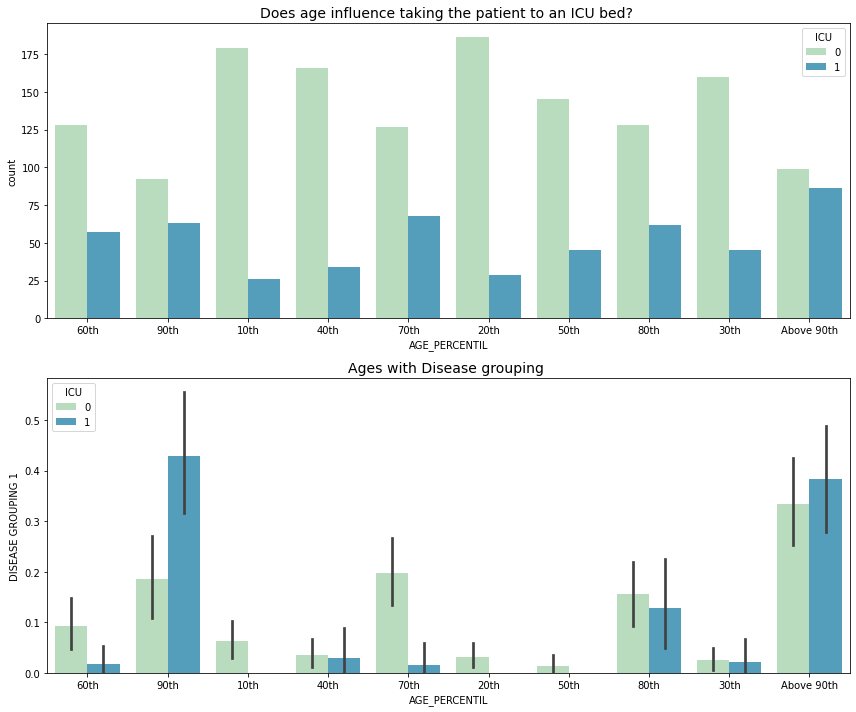

In [ ]:
# Does age influence taking the patient to an ICU bed?
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.title('Does age influence taking the patient to an ICU bed? ', fontsize=14)
sns.countplot(df['AGE_PERCENTIL'], hue='ICU', data=df, palette='GnBu')

print('\n')

# Ages with Disease Grouping 1
plt.subplot(2,1,2)
plt.title('Ages with Disease grouping ', fontsize=14)
sns.barplot(df['AGE_PERCENTIL'], y='DISEASE GROUPING 1', hue='ICU', data=df, palette='GnBu')
plt.tight_layout()


**Preprocess data**

As we have already seen, we have many features making the set with a high dimension, something that we must deal with in the feature engineering stage.


**Feature Engineering**

In [ ]:
## Separating features columns like the starter notebook
comorb_lst = [i for i in df.columns if "DISEASE" in i]
comorb_lst.extend(["HTN", "IMMUNOCOMPROMISED", "OTHER"])

demo_lst = [i for i in df.columns if "AGE_" in i]
demo_lst.append("GENDER")

vitalSigns_lst = df.iloc[:,193:-2].columns.tolist()

lab_lst = df.iloc[:,13:193].columns.tolist()

# convert age percentile to ordinal
pcts = sorted(df.AGE_PERCENTIL.unique())
age_percentile_encoding = {k: i for i, k in enumerate(pcts)}
df.AGE_PERCENTIL = df.AGE_PERCENTIL.replace(age_percentile_encoding)


**Handling missing data**

As laid out in the tips, it is quite reasonable to assume that a patient who does not have a measurement recorded in a time window is clinically stable, potentially presenting vital signs and blood labs similar to neighboring windows. Therefore, I will fill the missing values using an iterative approach by applying a foward fill and then a backward fill.


In [ ]:
df = df\
    .sort_values(by=['PATIENT_VISIT_IDENTIFIER', 'WINDOW'])\
    .groupby('PATIENT_VISIT_IDENTIFIER', as_index=False)\
    .fillna(method='ffill')\
    .fillna(method='bfill')


**Handling the windows**

From tips, it is noted that whereas a predictive model using all time windows will probably yield a greater accuracy, a nice model using only the first (0-2) is likely to be more clinically relevant and not to use the data when the target variable (ICU) is present (1), as it is unknown if the lab results were available before the patient was admitted into ICU (maybe the target event happened before the results were obtained). We will discard the data when ICU admission was during window (0-2) and consider the event that happened at any next window but using those features of window (0-2).


In [ ]:
# ICU per window
pd.crosstab(df.WINDOW, df.ICU)


ICU,0,1
WINDOW,,
0-2,353,32
2-4,326,59
4-6,286,99
6-12,255,130
ABOVE_12,190,195


Result must be 353 unique patients admitted in window (0-2)

In [ ]:
# discar unreliable data (admitted 0-2)
mask_unreliable = (df.WINDOW == '0-2') & (df.ICU == 1)
training_data = df.loc[~mask_unreliable]

# ICU admitted after window 0-2 or not
icu_above_2 = training_data.groupby('PATIENT_VISIT_IDENTIFIER')\
    .agg({'ICU': max})\
    .reset_index()\
    .rename(columns={'ICU': 'ICU_NEW'})
    
# merge back to original df
training_data = training_data.merge(icu_above_2, on=['PATIENT_VISIT_IDENTIFIER'], how='left')


In [ ]:
# valid cases per window
pd.crosstab(training_data.WINDOW, training_data.ICU)


ICU,0,1
WINDOW,,
0-2,353,0
2-4,326,59
4-6,286,99
6-12,255,130
ABOVE_12,190,195


No invalid cases (ICU = 1 and WINDOW = '0-2')

In [ ]:
# keep only features from 0-2 hour window
mask_02 = training_data.WINDOW == '0-2'
training_data = training_data.loc[mask_02]
# valid cases for training
pd.crosstab(training_data.WINDOW, training_data.ICU_NEW)


ICU_NEW,0,1
WINDOW,,
0-2,190,163


In [ ]:
# shape of training data

training_data.shape


(353, 232)

# **Model Creation**

I will use a couple of machine learning algorithms and interpret them post hoc via Shapley values.


In [ ]:
# features
features = ['AGE_PERCENTIL', 'GENDER'] + comorb_lst + lab_lst + vitalSigns_lst
X = training_data[features]
y = training_data['ICU_NEW']

# cross val
n_splits = 5
n_repeats = 10
seed = 2020
cv = model_selection.RepeatedStratifiedKFold(n_splits, n_repeats, random_state=seed)



In [ ]:
def cross_val_score_report(model, X, y, scoring_metrics, cv, n_jobs=-1):
    mean_scores = dict()
    for scoring in scoring_metrics:
        scores = model_selection.cross_val_score(
            model, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs)
        mean_scores[scoring] = scores
        print(f'{scoring} CV Mean: {np.mean(scores):.3f} (Std: {np.std(scores):.3f})')
    return mean_scores



**Random Forest**

In [ ]:
rf = ensemble.RandomForestClassifier(
    n_estimators=1000,
    max_depth=4,
    min_weight_fraction_leaf=0.02,
    random_state=seed,
    n_jobs=-1,
    oob_score=True,
    max_features='sqrt')

model1 = rf

# cross val
scoring_metrics = ['roc_auc', 'precision', 'recall', 'f1', 'accuracy']
model1_scores = cross_val_score_report(
    model1, X, y, cv=cv, scoring_metrics=scoring_metrics)


roc_auc CV Mean: 0.796 (Std: 0.040)
precision CV Mean: 0.727 (Std: 0.055)
recall CV Mean: 0.619 (Std: 0.077)
f1 CV Mean: 0.666 (Std: 0.052)
accuracy CV Mean: 0.715 (Std: 0.038)


# **Model Evaluation**

In [ ]:
!pip install shap

     |████████████████████████████████| 276kB 3.4MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394124 sha256=c2cc70c4f7eabebe8459ed85f31a7f72fd42fa97a350bce0088a9c80866c687d
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [ ]:
import shap
shap.initjs()


In [ ]:
def cross_val_shap(model, X, y, cv, explainer_type='kernel', 
                   random_state=seed, n_jobs=-1, 
                   feature_perturbation='tree_path_dependent',
                   model_output='raw'):
    # cross val shap
    cv_shap = list()
    expec_values = list()
    test_ixs = list()
    # loop folds
    for train_ix, test_ix in cv.split(X, y):
        # split train/test
        X_train, y_train = X.iloc[train_ix], y.iloc[train_ix]
        X_test, y_test = X.iloc[test_ix], y.iloc[test_ix]
        # fit model
        m = base.clone(model)
        m.fit(X_train, y_train)
        # explain
        if explainer_type == 'tree':
            if feature_perturbation == 'interventional':
                data = X_train
            else:
                data = None
            explainer = shap.TreeExplainer(m, 
                                           data=data,
                                           feature_perturbation=feature_perturbation,
                                           model_output=model_output)
            shap_values = explainer.shap_values(X_test, check_additivity=False)
            cv_shap.append(shap_values)
            expec_values.append(explainer.expected_value)
            test_ixs.append(test_ix)
        elif explainer_type == 'kernel':
            explainer = shap.KernelExplainer(m.predict_proba, X_train, link='logit')
            shap_values = explainer.shap_values(X_test)
            cv_shap.append(shap_values)
            expec_values.append(explainer.expected_value)
            test_ixs.append(test_ix)
        else:
            raise NotImplementedError
            
    # aggregate shap values
    test_set = test_ixs[0]
    cv_shap_agg = np.array(cv_shap[0])
    expec_values_agg = np.array(expec_values[0])
    for i in range(len(test_ixs)):
        test_set = np.concatenate((test_set, test_ixs[i]), axis=0)
        cv_shap_agg = np.concatenate((cv_shap_agg, np.array(cv_shap[i])), axis=1)
        expec_values_agg = np.concatenate((expec_values_agg, np.array(expec_values[i])), axis=0)
    #bringing back variable names    
    X_test = X.iloc[test_set]
    
    return cv_shap_agg, cv_shap, expec_values_agg, X_test


In [ ]:
import shap
shap.initjs()

shap_cv_agg_model1, shap_cv_model1, expec_value_model1, X_test_model1 = cross_val_shap(
    model1, X, y, cv=cv, explainer_type='tree')


**Summary plots**

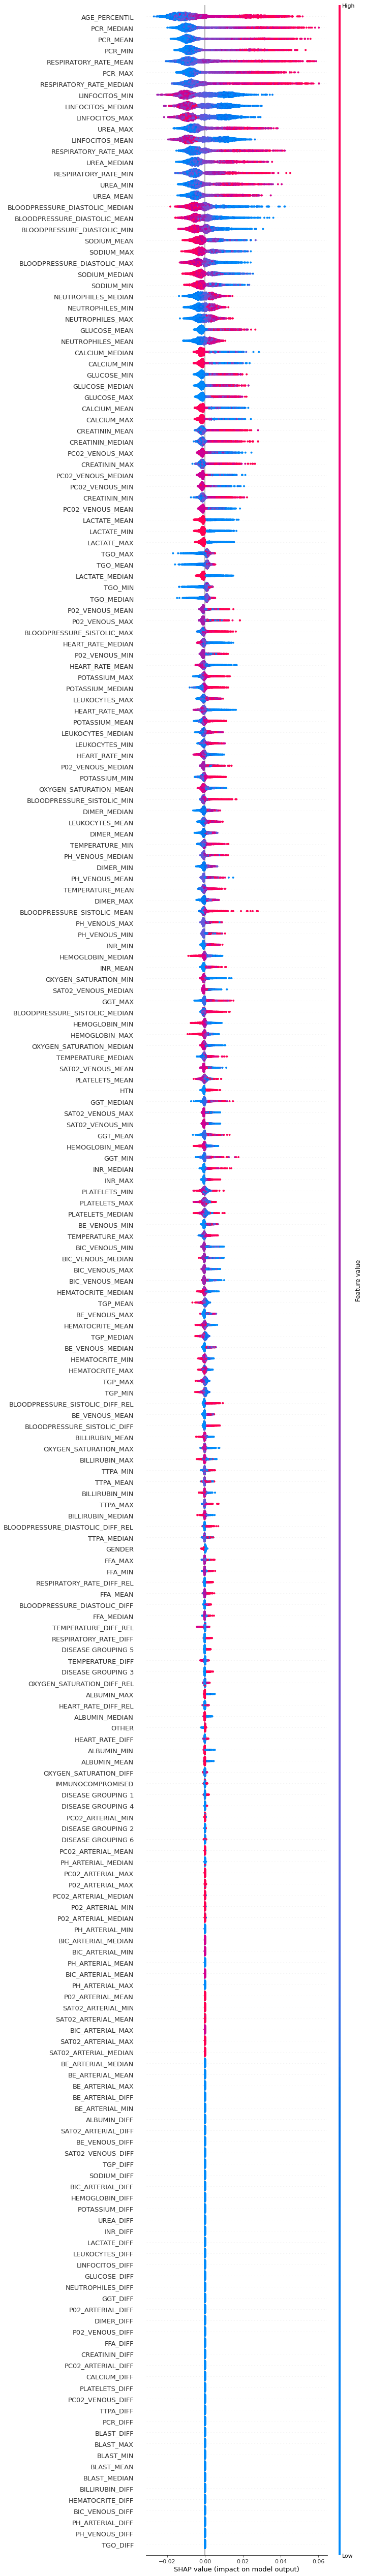

In [ ]:
# let's plot summary SHAP plots of every 20 features (ordered)
n_plot = 20
n_feats = X.shape[1]

# sort features based on sum of abs shap values
feature_order = np.argsort(np.sum(np.abs(shap_cv_agg_model1[1]), axis=0))[::-1]

# plot
shap.summary_plot(shap_cv_agg_model1[1], 
                  X_test_model1,
                  max_display=n_feats)


The vast majority of the features behave very linearly (globally) and all expanded statistics (MEAN, MIN, MAX, etc.) seem to behave in the same way. With that, let's simplify de model a bit and use only MEDIAN features.

In [ ]:
# mean features
lab_median = [xi for xi in lab_lst if xi.endswith('MEDIAN')]
vital_median = [xi for xi in vitalSigns_lst if xi.endswith('MEDIAN')]

# feature and target
# features
features = ['AGE_PERCENTIL', 'GENDER'] + comorb_lst + lab_median + vital_median
X = training_data[features]
y = training_data['ICU_NEW']


In [ ]:
X.shape

(353, 53)

In [ ]:
rf = ensemble.RandomForestClassifier(
    n_estimators=1000,
    max_depth=4,
    min_weight_fraction_leaf=0.02,
    random_state=seed,
    n_jobs=-1,
    oob_score=True,
    max_features='sqrt')

model2 = rf

# cross val
scoring_metrics = ['roc_auc', 'precision', 'recall', 'f1', 'accuracy']
model2_scores = cross_val_score_report(
    model2, X, y, cv=cv, scoring_metrics=scoring_metrics)


roc_auc CV Mean: 0.806 (Std: 0.041)
precision CV Mean: 0.732 (Std: 0.057)
recall CV Mean: 0.635 (Std: 0.083)
f1 CV Mean: 0.676 (Std: 0.056)
accuracy CV Mean: 0.722 (Std: 0.040)


Performance metrics are slightly better, which is good news, since we did not lose predictive information removing those features. Let's check the SHAP values

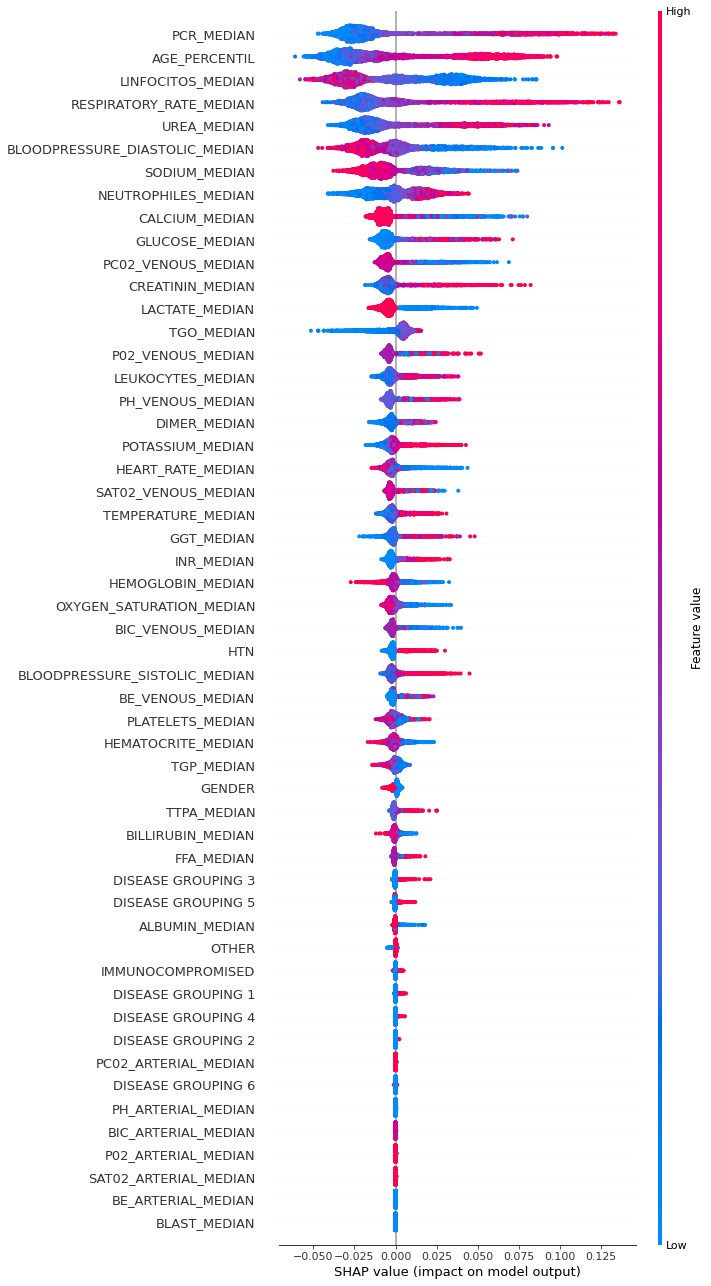

In [ ]:
shap_cv_agg_model2, shap_cv_model2, expec_value_model2, X_test_model2 = cross_val_shap(
    model2, X, y, cv=cv, explainer_type='tree')

# sort features based on sum of abs shap values
feature_order = np.argsort(np.sum(np.abs(shap_cv_agg_model2[1]), axis=0))[::-1]
n_feats = X.shape[1]

# plot
shap.summary_plot(shap_cv_agg_model2[1], 
                  X_test_model2,
                  max_display=n_feats)


Feature with zero impact either are really irrelevant or might have not been used in any of the trees 

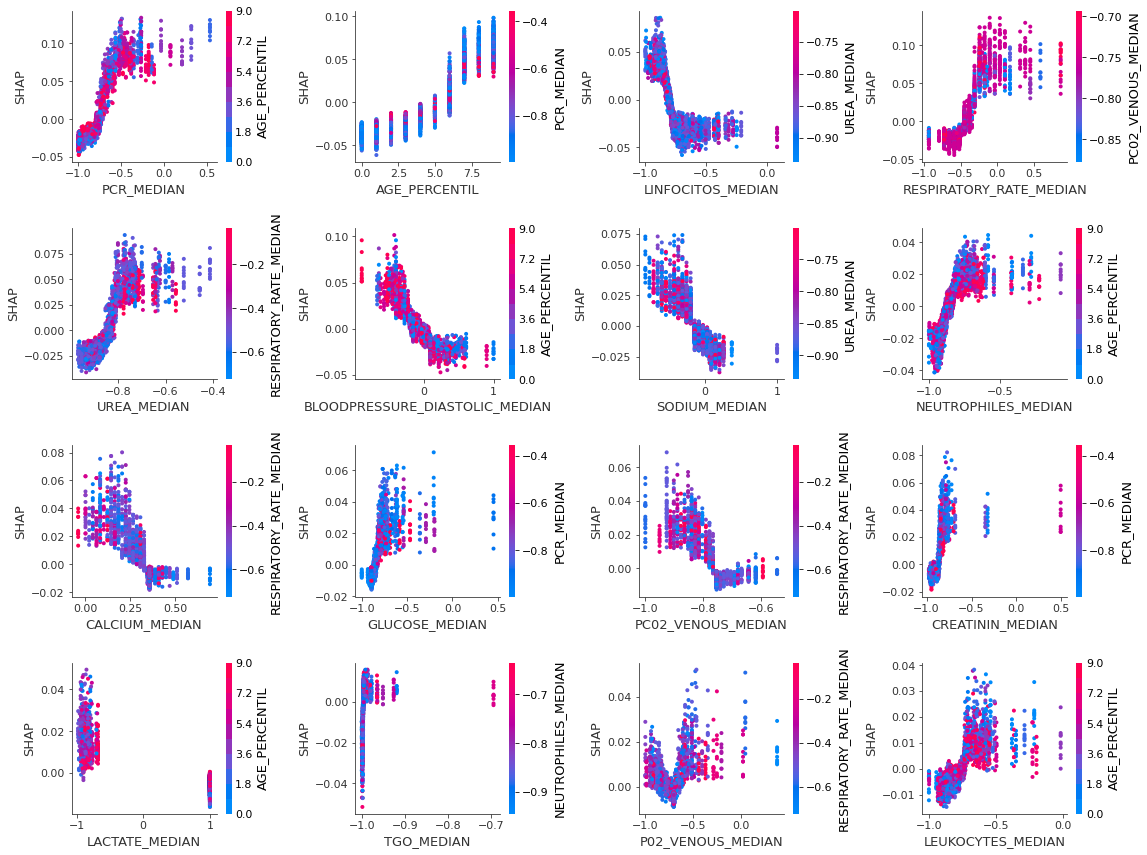

In [ ]:
# let's check dependence plot for top features
fig, ax = plt.subplots(4, 4, figsize=(16, 12))
for f, axi in zip(X.columns[feature_order[:16]], ax.flatten()):
    shap.dependence_plot(f, shap_cv_agg_model2[1], X_test_model2, ax=axi, show=False)
    axi.set_ylabel('SHAP')
    
fig.tight_layout()


**Clustering**

Let's use SHAP values for supervised clustering and see if any interesting pattern emerges.


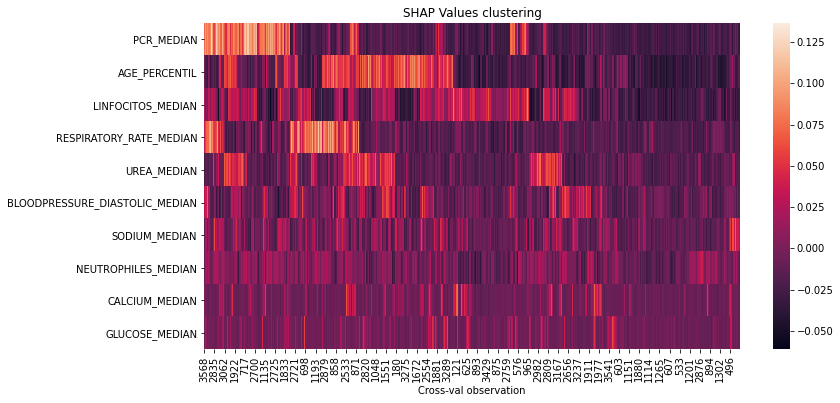

In [ ]:
import seaborn as sns
import scipy.cluster

# clustering
D = scipy.spatial.distance.pdist(shap_cv_agg_model2[1], 'sqeuclidean')
clustOrder = scipy.cluster.hierarchy.leaves_list(scipy.cluster.hierarchy.complete(D))

# clustermap only top10 features
data_plot = pd.DataFrame(shap_cv_agg_model2[1], columns=X.columns).iloc[clustOrder]
top_10_feat = X.columns[feature_order[:10]]

plt.figure(figsize=(12, 6))
sns.heatmap(data_plot[top_10_feat].T)
plt.title('SHAP Values clustering')
plt.xlabel('Cross-val observation');


There are some clear clusters:

PCR,

Respiratory

Age (both with high SHAP values, in the mid-left, and low SHAP values, in the middle going to the right)

Linfocitos (also both high and low SHAP values)

Sodium



Still, SHAP values does not give us any insights about original variable values. Let's check it


In [ ]:
import scipy.cluster

clusters = scipy.cluster.hierarchy.fclusterdata(shap_cv_agg_model2[1], 
                                                t=0.7*D.max(),
                                                criterion='distance',
                                                metric='sqeuclidean',
                                                method='complete')

clusters.max()


4

Cluster and ICU Risk

In [ ]:
y[X_test_model2.index].groupby(clusters).mean()

1    0.701031
2    0.756522
3    0.605965
4    0.271072
Name: ICU_NEW, dtype: float64

Cluster 1 and 2 have more than 70% of ICU admitted patients, while 4th cluster less than 30%. Let's check the features for more insights.

In [ ]:
X_test_model2.groupby(clusters)[X.columns[feature_order]].mean().T.style.background_gradient(axis=1)

,1,2,3,4
PCR_MEDIAN,-0.409977,-0.825663,-0.902141,-0.896593
AGE_PERCENTIL,4.804124,6.376087,7.637363,2.490635
LINFOCITOS_MEDIAN,-0.805111,-0.767829,-0.784952,-0.738992
RESPIRATORY_RATE_MEDIAN,-0.408046,-0.054573,-0.531099,-0.538842
UREA_MEDIAN,-0.842670,-0.812059,-0.823767,-0.870436
BLOODPRESSURE_DIASTOLIC_MEDIAN,0.010988,-0.093103,-0.114793,-0.013971
SODIUM_MEDIAN,-0.175650,-0.146253,-0.124677,-0.068936
NEUTROPHILES_MEDIAN,-0.759427,-0.808626,-0.838140,-0.856529
CALCIUM_MEDIAN,0.314749,0.319809,0.323631,0.331627
GLUCOSE_MEDIAN,-0.843435,-0.858619,-0.845756,-0.851828


**General summary of clusters:**

Cluster 1: Greater PCR, Age percentile 60th, smaller Linfocitos and higher Diastolic Blood Pressure, high Temperature, mostly men;

Cluster 2: Medium PCR, Age percentile 70-80th, high Respiratory Rate;

Cluster 3: Low PCR, Age percentile 80-90th, higher incident of comorbities, low Temperature;

Cluster 4: Low PCR, youngest people 30-40th percentile, low Temperature, highest Calcium, Linfocitos, Sodium, Hemoglobin, Oxygen Sautration.


**Conclusion**

This is a model built with only "0-2 window", which is clinically relevant as the dataset authors pointed out, with 74% precision. 
Moreover, SHAP values gave us a better understand of underlying factor that affect ICU risk and a way of clustering into groups. It is worth noticing that we can relax the clustering constraint in order to create more or less cluster that are clinically relevant, but this needs expert orientation.


Notebook done and submitted by

Terence Tachiona

tachiona0607@gmail.com

on 20 July 2020
